## THYROID NODULE CANCER DETECTION - 85 % accuracy

EXPERIMENTATION DONE RIGHT

In [46]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [12]:

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import kagglehub
from PIL import Image
import cv2
import hashlib
from scipy.stats import skew, kurtosis

# ============================================================
# 1. DATASET DOWNLOAD USING KAGGLEHUB
# ============================================================

base_path = kagglehub.dataset_download("diveshzz/thyroid-cancer-classification-ultrasound-dataset")
DATASET_PATH = os.path.join(base_path, "Thyroid Data")

print("✅ Dataset downloaded successfully!")
print("📂 Dataset Path:", DATASET_PATH)

print("\n📁 Dataset Folder Contents:", os.listdir(DATASET_PATH))


Using Colab cache for faster access to the 'thyroid-cancer-classification-ultrasound-dataset' dataset.
✅ Dataset downloaded successfully!
📂 Dataset Path: /kaggle/input/thyroid-cancer-classification-ultrasound-dataset/Thyroid Data

📁 Dataset Folder Contents: ['0', '1']


In [13]:
import os
import pandas as pd

# Base training directory
base_path = DATASET_PATH

# Class labels as subfolder names
categories = ['0', '1']

# Collect image paths and labels
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        if image_name.lower().endswith(('.png', '.jpg', '.jpeg')):  # only image files
            image_path = os.path.join(category_path, image_name)
            image_paths.append(image_path)
            labels.append(int(category))  # convert string '0' or '1' to int

# Create DataFrame
df = pd.DataFrame({
    "image_path": image_paths,
    "label": labels
})

# Preview the DataFrame
print("Loaded dataset:")
print(df.head())
print(f"\nTotal images: {len(df)}")
print(f"Class distribution:\n{df['label'].value_counts()}")

Loaded dataset:
                                          image_path  label
0  /kaggle/input/thyroid-cancer-classification-ul...      0
1  /kaggle/input/thyroid-cancer-classification-ul...      0
2  /kaggle/input/thyroid-cancer-classification-ul...      0
3  /kaggle/input/thyroid-cancer-classification-ul...      0
4  /kaggle/input/thyroid-cancer-classification-ul...      0

Total images: 3115
Class distribution:
label
0    1905
1    1210
Name: count, dtype: int64


EDA

In [14]:
df.head()

,image_path,label
0,/kaggle/input/thyroid-cancer-classification-ul...,0
1,/kaggle/input/thyroid-cancer-classification-ul...,0
2,/kaggle/input/thyroid-cancer-classification-ul...,0
3,/kaggle/input/thyroid-cancer-classification-ul...,0
4,/kaggle/input/thyroid-cancer-classification-ul...,0


In [15]:
df.shape

(3115, 2)

In [16]:
df.columns

Index(['image_path', 'label'], dtype='object')

In [17]:
df.duplicated().sum()

np.int64(0)

In [18]:
df['label'].value_counts()

,count
label,
0,1905
1,1210


DATA VISUALIZATION

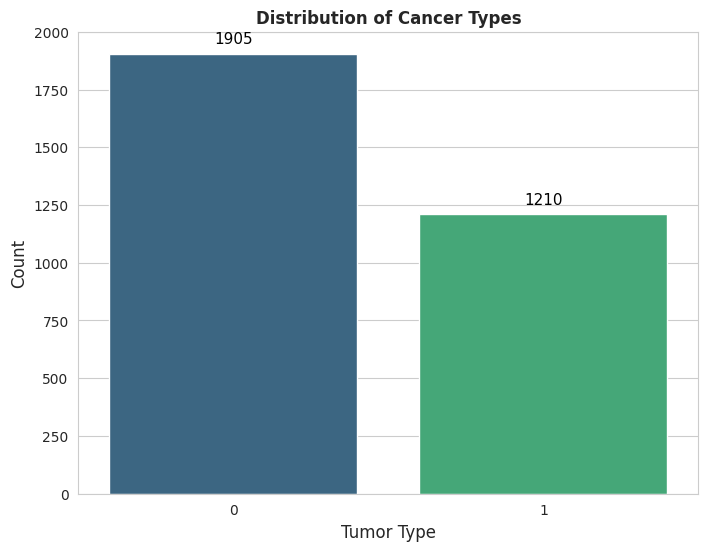

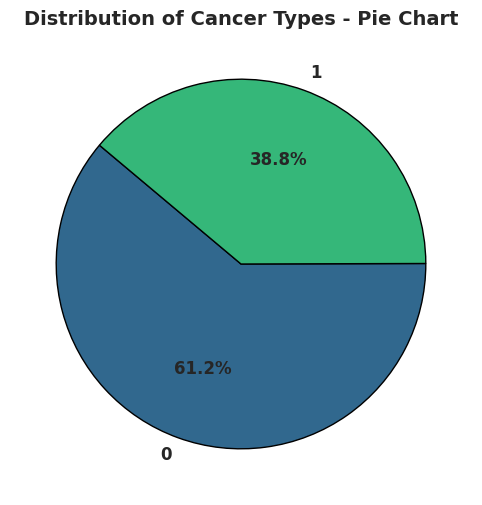

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)

ax.set_title("Distribution of Cancer Types", fontsize=12, fontweight='bold')
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=11, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.show()

label_counts = df["label"].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.color_palette("viridis", len(label_counts))

ax.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%',
       startangle=140, colors=colors, textprops={'fontsize': 12, 'weight': 'bold'},
       wedgeprops={'edgecolor': 'black', 'linewidth': 1})

ax.set_title("Distribution of Cancer Types - Pie Chart", fontsize=14, fontweight='bold')

plt.show()

IMBALANCED

SEE MY DATA

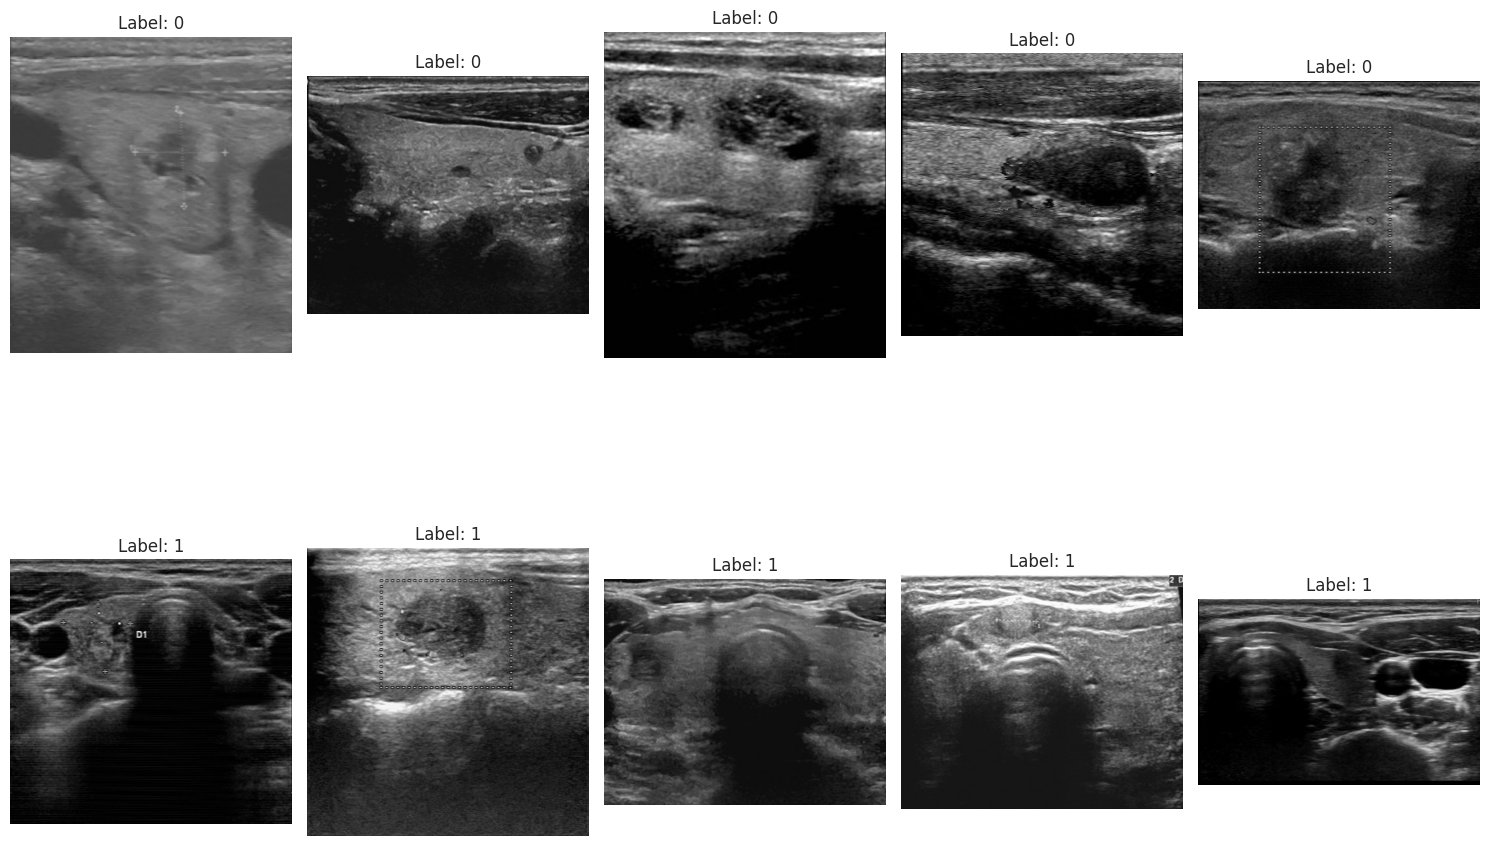

In [20]:
import cv2
import matplotlib.pyplot as plt

num_images = 5
categories = ['0', '1']  # keep as strings, fix inside loop

plt.figure(figsize=(15, 12))

for i, category in enumerate(categories):
    category_int = int(category)  # fix: convert to int for filtering
    category_images = df[df['label'] == category_int]['image_path'].iloc[:num_images]

    for j, img_path in enumerate(category_images):

        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(len(categories), num_images, i * num_images + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Label: {category}")
        else:
            print(f"⚠️ Failed to load image: {img_path}")

plt.tight_layout()
plt.show()

DATA AUGMENTATION

In [21]:
import pandas as pd

# Step 1: Separate minority and majority class
majority_class = df[df['label'] == 0]
minority_class = df[df['label'] == 1]

# Step 2: Upsample the minority class
minority_upsampled = minority_class.sample(n=len(majority_class), replace=True, random_state=42)

# Step 3: Combine the two
df_resampled = pd.concat([majority_class, minority_upsampled]).sample(frac=1, random_state=42).reset_index(drop=True)

# Step 4: Encode labels if needed
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_resampled['category_encoded'] = label_encoder.fit_transform(df_resampled['label'])

# Show new class distribution
print("\n✅ Class distribution after manual upsampling:")
print(df_resampled['category_encoded'].value_counts())


✅ Class distribution after manual upsampling:
category_encoded
0    1905
1    1905
Name: count, dtype: int64


MODEL TRAINING

In [25]:
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print ('check')

check


TRAIN TEST VAL SPLIT

In [27]:
train_df_new, temp_df_new = train_test_split(
    df_resampled,
    train_size=0.8,
    shuffle=True,
    random_state=42,
    stratify=df_resampled['category_encoded']
)

In [28]:
valid_df_new, test_df_new = train_test_split(
    temp_df_new,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    stratify=temp_df_new['category_encoded']
)

CONFIG

In [29]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new,
    x_col='image_path',
    y_col='category_encoded',
    target_size=img_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    batch_size=batch_size
)

Found 3048 validated image filenames belonging to 2 classes.
Found 381 validated image filenames belonging to 2 classes.
Found 381 validated image filenames belonging to 2 classes.


GPU SETUP

In [30]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [31]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is set for TensorFlow")
    except RuntimeError as e:
        print(e)

Physical devices cannot be modified after being initialized


MODEL TRAINING

In [32]:
import tensorflow as tf
from tensorflow.keras import layers, Model

FOR SKIP CONNECTIONS

In [33]:
class Avg2MaxPooling(layers.Layer):
    """Novel Avg-2Max Pooling layer (as per paper)"""
    def __init__(self, pool_size=3, strides=2, padding='same'):
        super(Avg2MaxPooling, self).__init__()
        self.avg_pool = layers.AveragePooling2D(pool_size, strides, padding)
        self.max_pool = layers.MaxPooling2D(pool_size, strides, padding)

    def call(self, inputs):
        return self.avg_pool(inputs) - (self.max_pool(inputs) + self.max_pool(inputs))  # To explicitly emphasizes on edges

In [34]:
class DepthwiseSeparableConv(layers.Layer):
    """Depthwise Separable Convolution with ReLU"""
    def __init__(self, filters, kernel_size=3, strides=1): # point wise
        super(DepthwiseSeparableConv, self).__init__()
        self.dw = layers.DepthwiseConv2D(kernel_size, strides, padding='same')
        self.pw = layers.Conv2D(filters, 1, strides=1)
        self.bn = layers.BatchNormalization()

    def call(self, inputs):
        x = self.dw(inputs)
        x = self.pw(x)
        return tf.nn.relu(self.bn(x))

def create_fibonacci_net(input_shape=(224, 224, 3), num_classes=1):
    inputs = layers.Input(shape=input_shape)

    # Block Architecture Starts

    # --- Block 1 (21 filters) ---
    x = layers.Conv2D(21, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)  # 112x112

    # --- Block 2 (34 filters) ---
    x = layers.Conv2D(34, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x2 = layers.ReLU()(x)  # Save for pcb1 (56x56x34)
    x = layers.MaxPooling2D(2)(x)  # 56x56

    # --- Block 3 (55 filters) ---
    x = layers.Conv2D(55, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x3 = layers.ReLU()(x)  # Save for pcb2 (28x28x55)
    x = layers.MaxPooling2D(2)(x)  # 28x28

    # --- pcb1: Block 2 → Block 4 ---
    pcb1 = layers.Conv2D(24, 3, padding='same')(x2)  # 56x56x24
    pcb1 = Avg2MaxPooling()(pcb1)  # 28x28x24
    pcb1 = layers.Conv2D(24, 3, padding='same')(pcb1)  # Maintain 28x28x24
    pcb1 = Avg2MaxPooling()(pcb1)  # 14x14x24 (now matches Block 4)

    # --- Block 4 (89 filters) ---
    x = layers.Conv2D(89, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)  # 14x14x89

    # Resize pcb1 to match x
    pcb1 = layers.Resizing(14, 14)(pcb1)

    x = layers.concatenate([x, pcb1])  # 14x14x(89+24)

    # --- pcb2: Block 3 → Block 5 ---
    pcb2 = layers.Conv2D(24, 3, padding='same')(x3)  # 28x28x24
    pcb2 = Avg2MaxPooling()(pcb2)  # 14x14x24
    pcb2 = layers.Conv2D(24, 3, padding='same')(pcb2)  # Maintain 14x14x24
    pcb2 = Avg2MaxPooling()(pcb2)  # 7x7x24 (matches Block 5)

    # --- Block 5 (144 filters) ---
    x = layers.Conv2D(144, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)  # 7x7x144

    # Resize pcb2 to match x
    pcb2 = layers.Resizing(7, 7)(pcb2)

    x = layers.concatenate([x, pcb2])  # 7x7x(144+24)

    # --- Block 6 (233 filters, DWSC) ---
    x = DepthwiseSeparableConv(233)(x)  # 7x7x233

    # --- Block 7 (377 filters, DWSC) ---
    x = DepthwiseSeparableConv(377)(x)  # 7x7x377

    # --- Output ---
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    return Model(inputs, outputs)

In [35]:
model = create_fibonacci_net(num_classes=1)  # For 2-class tumor classification
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 224, 224,  │        588 │ input_layer_1[0]… │
│                     │ 21)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │         84 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 21)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 21)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 112, 112,  │          0 │ re_lu_5[0][0]     │
│ (MaxPooling2D)      │ 21)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 112, 112,  │      6,460 │ max_pooling2d_9[… │
│                     │ 34)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        136 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 34)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 34)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 56, 56,    │     16,885 │ max_pooling2d_10… │
│                     │ 55)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        220 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 55)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_6 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 34)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 55)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 112, 112,  │      7,368 │ re_lu_6[0][0]     │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 28, 28,    │     44,144 │ max_pooling2d_11… │
│                     │ 89)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ avg2_max_pooling_4  │ (None, 56, 56,    │          0 │ conv2d_14[0][0]   │
│ (Avg2MaxPooling)    │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        356 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 89)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 56, 56,    │      5,208 │ avg2_max_pooling

 Total params: 380,152 (1.45 MB)

 Trainable params: 378,246 (1.44 MB)

 Non-trainable params: 1,906 (7.45 KB)

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

EARLY STOPPING

In [37]:
# Callbacks to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

MODEL TRAIN

In [38]:
# Fit the model
history1 = model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=30,
    batch_size=32,           # Kept same as your original
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 56s 185ms/step - accuracy: 0.6153 - auc_1: 0.6630 - loss: 0.6504 - val_accuracy: 0.4987 - val_auc_1: 0.5642 - val_loss: 0.6928 - learning_rate: 1.0000e-04
Epoch 2/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.6973 - auc_1: 0.7669 - loss: 0.5795 - val_accuracy: 0.6299 - val_auc_1: 0.6893 - val_loss: 0.6761 - learning_rate: 1.0000e-04
Epoch 3/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.7278 - auc_1: 0.8095 - loss: 0.5367 - val_accuracy: 0.6982 - val_auc_1: 0.7853 - val_loss: 0.6074 - learning_rate: 1.0000e-04
Epoch 4/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.7766 - auc_1: 0.8549 - loss: 0.4893 - val_accuracy: 0.6588 - val_auc_1: 0.7913 - val_loss: 0.6308 - learning_rate: 1.0000e-04
Epoch 5/30
191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8144 - auc_1: 0.8973 - loss: 0.4290
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step -

MODEL EVALUTAION

In [39]:
from sklearn.metrics import confusion_matrix, classification_report

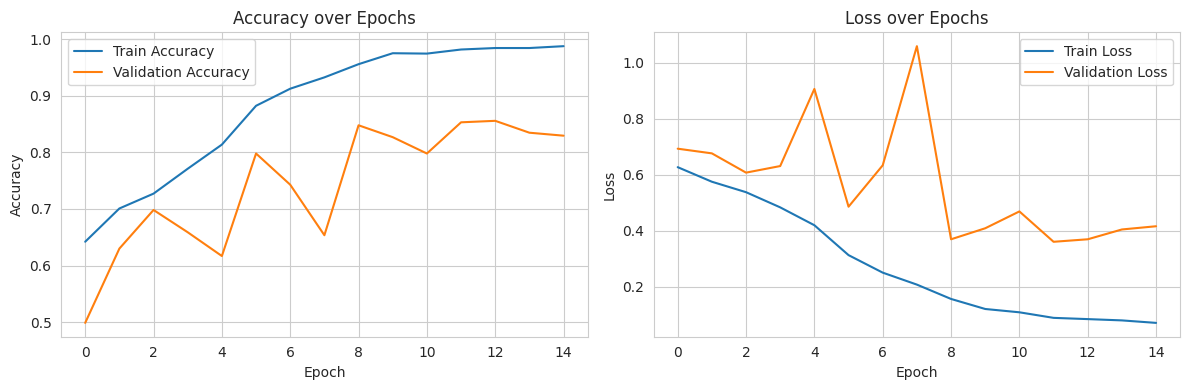

In [40]:
def plot_history(history1):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Train Accuracy')
    plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Train Loss')
    plt.plot(history1.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history1)

In [41]:
test_gen_new.reset()
y_true = test_gen_new.classes
y_pred_probs = model.predict(test_gen_new, steps=len(test_gen_new))
y_pred = (y_pred_probs > 0.5).astype(int)

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step


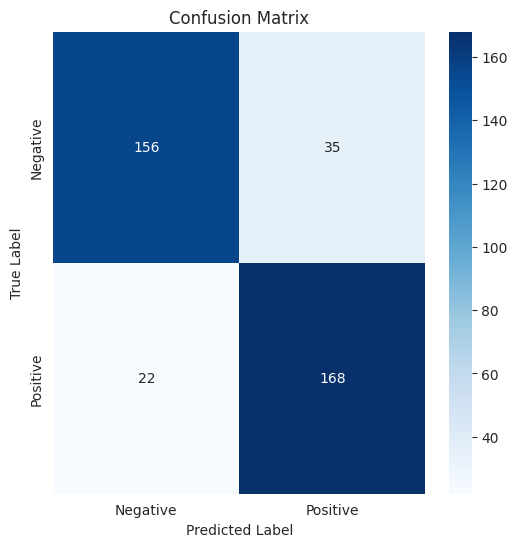

In [42]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(y_true, y_pred)

CLASSIFICATION REPORT


Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.82      0.85       191
    Positive       0.83      0.88      0.85       190

    accuracy                           0.85       381
   macro avg       0.85      0.85      0.85       381
weighted avg       0.85      0.85      0.85       381



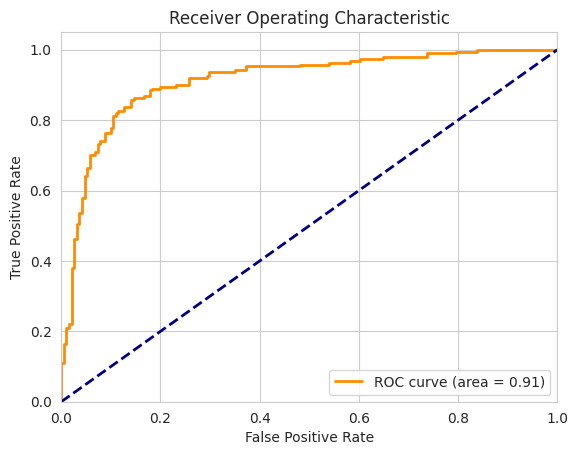

In [43]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

SAVE THE MODEL

In [45]:
# Save the full model (architecture + weights + optimizer)
model.save("thyroid_cancer_model.keras")

## GRAD CAM

ASSIGNMENT : FIGURE OUT THE CODE

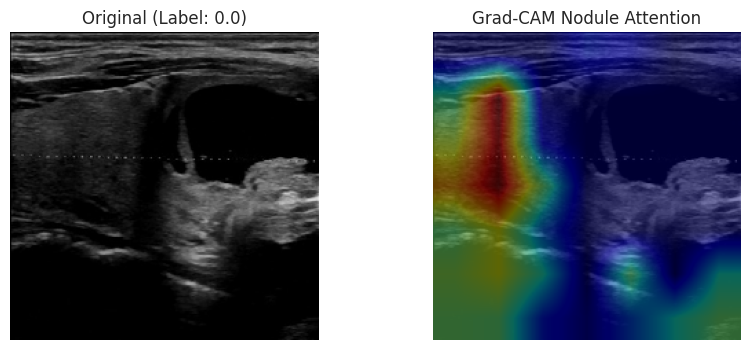

In [48]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            # For binary classification with sigmoid, we look at the single output value
            class_channel = preds[:, 0]
        else:
            class_channel = preds[:, pred_index]

    # This is the gradient of the output node with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Select a sample from the test generator
# ImageDataGenerator returns (x, y) batches
test_gen_new.reset()
sample_batch_x, sample_batch_y = next(test_gen_new)
img_sample = sample_batch_x[0:1] # Take first image of batch
label_sample = sample_batch_y[0]

# Find the last layer of the DWSC tail
# Your FibonacciNet uses DepthwiseSeparableConv layers
last_conv_name = None
for layer in reversed(model.layers):
    if isinstance(layer, DepthwiseSeparableConv) or "depthwise_separable_conv" in layer.name:
        last_conv_name = layer.name
        break

if last_conv_name:
    heatmap = make_gradcam_heatmap(img_sample, model, last_conv_name)

    # Display result
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_sample[0])
    plt.title(f"Original (Label: {label_sample})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_sample[0])
    # Resize heatmap to match image size
    resized_heatmap = cv2.resize(heatmap, (img_size[0], img_size[1]))
    plt.imshow(resized_heatmap, alpha=0.4, cmap='jet')
    plt.title("Grad-CAM Nodule Attention")
    plt.axis('off')
    plt.show()
else:
    print("Could not find a valid convolutional layer for Grad-CAM.")